# 1. Importación de librerías y carga de datos

In [1]:
# Ni escalado ni estandarizado
SCALED=False
STANDARIZED=False

In [2]:
# Importamos las librerías necesarias

import haversine as hs
import pandas as pd
import numpy as np
import pickle
import time
import os

import tensorflow as tf
tf.config.run_functions_eagerly(True)
from keras.models import Sequential
from keras.optimizers import Adam, SGD
from keras.layers import LSTM, GRU, Dense, Reshape, Dropout, Bidirectional, \
  RepeatVector, TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from haversine import inverse_haversine, Direction
from attention import Attention

if SCALED:
    from sklearn.preprocessing import MinMaxScaler
elif STANDARIZED:
    from sklearn.preprocessing import StandardScaler

from shapely import geometry
import geopy
import geopy.distance
import math

import matplotlib.pyplot as plt

from codecarbon import EmissionsTracker

C:\Users\sandr\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [3]:
# Hacemos el resultado reproducible
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

# Declaramos el tipo de float, en este caso float64
tf.keras.backend.set_floatx('float64')

In [4]:
# Leemos y guardamos la info de segudo y vehículo
df = pd.read_csv('positions.csv')

columns = ['time(s)', 'vehicle_id']
df = df[columns]
df = df.sort_values(by=['vehicle_id', 'time(s)'])
df.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id
0,1.0,0
31,2.0,0
64,3.0,0
100,4.0,0
158,5.0,0


In [5]:
df_data = pd.read_csv('positions.csv')
df_data = df_data.sort_values(by=['vehicle_id', 'time(s)'])
df_data.head()

C:\Users\sandr\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,time(s),vehicle_id,victim_id,shape_collider,shape_victim,latitude(m),longitude(m),speed(m/s),heading,acceleration(m/s²),collision
0,1.0,0,-1,passenger,-1,41.402717,2.137950,14.723400,137.798227,0.000000,0
31,2.0,0,-1,passenger,-1,41.402633,2.138082,14.418443,128.510085,-0.304957,0
64,3.0,0,-1,passenger,-1,41.402549,2.138213,14.193703,128.510085,-0.224740,0
100,4.0,0,-1,passenger,-1,41.402468,2.138340,13.853303,135.176752,-0.340400,0
158,5.0,0,-1,passenger,-1,41.402378,2.138462,14.350286,135.176752,0.496983,0


In [6]:
# Load MinMaxScaler for target variables
if SCALED:
    MINMAXSCALER_FILE = './minmaxscaler.pkl'#os.path.join("TFM", "implementation",
                             #"data_preparation", "minmaxscaler.pkl")
    with open(MINMAXSCALER_FILE, 'rb') as f_minmaxscaler:
        minmaxscaler = pickle.load(f_minmaxscaler)
if STANDARIZED:
    TARGETS_STAND_FILE = './' #os.path.join("TFM", "implementation",
                                     #"data_preparation", "targets_stand.pkl")
    with open(TARGETS_STAND_FILE, 'rb') as f_scaler:
        standscaler_targets = pickle.load(f_scaler)

In [7]:
# Load training dataset
if SCALED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_scaled.npz")
elif STANDARIZED:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val_stand.npz")
else:
    DATASET_TRAIN = os.path.join('./',
                               "ventanas_no_coincidentes_train_val.npz")
    
npzfile = np.load(DATASET_TRAIN)
X_train = npzfile['X_train']
X_val = npzfile['X_val']
y_train = npzfile['y_train']
y_val = npzfile['y_val']
print("X_train: {}  y_train: {}\nX_val: {}  y_val: {}"
      .format(X_train.shape, y_train.shape, X_val.shape, y_val.shape))

# Load testing dataset
if SCALED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_scaled.npz")
elif STANDARIZED:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test_stand.npz")
else:
    DATASET_TEST = os.path.join('./',
                              "ventanas_no_coincidentes_test.npz")
npzfile = np.load(DATASET_TEST)
X_test = npzfile['X_test']
y_test = npzfile['y_test']
print("X_test: {}  y_test: {}".format(X_test.shape, y_test.shape))

# Load testing vehicle ids list
VEHICLE_IDS_FILE = os.path.join('./', "vehicle_ids.pkl")
with open(VEHICLE_IDS_FILE, 'rb') as f_vehicle_ids:
    vehicle_ids = pickle.load(f_vehicle_ids)
print("Vehicle_ids: {}".format(len(vehicle_ids)))

X_train: (6005877, 20, 5)  y_train: (6005877, 5, 5)
X_val: (2573948, 20, 5)  y_val: (2573948, 5, 5)
X_test: (2402, 20, 5)  y_test: (2402, 5, 5)
Vehicle_ids: 8972


In [8]:
# Load dataset with vehicles dimensions
DATASET_DIM = os.path.join('./', "dimensions.csv")
df_dim = pd.read_csv(DATASET_DIM)
df_dim = df_dim[['vehicle_id', 'length', 'width']]
df_dim.head()

,vehicle_id,length,width
0,0,5.0,1.8
1,2,5.0,1.8
2,3,5.0,1.8
3,4,2.2,0.9
4,5,5.0,1.8


In [9]:
# Load dataset with vehicles colision
#DATASET_COL = os.path.join('./', "collisions_1k.csv")
df_col = pd.read_csv('collisions_2k.csv')
df_col = df_col[['vehicle_id', 'victim_id']].astype(int)
df_col.head()

,vehicle_id,victim_id
0,1240,5722
1,209,802
2,863,300
3,6444,3528
4,798,2787


In [10]:
# Load dataset with vehicles no-colision
#DATASET_NOCOL = os.path.join('./', "no_collisions_1k.csv")
df_nocol = pd.read_csv('no_collisions_2k.csv')
df_nocol = df_nocol[['v1', 'v2']]
df_nocol.head()

,v1,v2
0,31477,34003
1,33063,33228
2,33130,33973
3,33268,33958
4,33268,34256


In [11]:
df_col.shape

(2120, 2)

In [12]:
df_nocol.shape

(2120, 2)

# 2. Generación y entrenamiento de los modelos

In [13]:
#if SCALED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "scaled")
#elif STANDARIZED:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "standarized")
#else:
#    MODELS_FOLDER = os.path.join("TFM", "implementation", "models", "real")
    
MODELS_FOLDER = './'

In [14]:
# Windows parameters
INPUT_WIDTH=20
OUTPUT_WIDTH=5
OFFSET_WIDTH=0

# Input and output columns
INPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']
OUTPUT_COL = ['latitude(m)', 'longitude(m)', 'heading', 'speed(m/s)', 'acceleration(m/s²)']

# Training parameters
EPOCHS= 10
BATCH_SIZE=64
PATIENCE=3
REDUCELR=0.2

# Define loss function
def physics_loss(y_true, y_pred):

    # Para facilitar el cálculo, hacemos un reshape de y_true para juntar las 64 muestras (batch_size)
    a,b,c = tf.shape(y_true)
    y_true = tf.reshape(y_true, [a.numpy()*b.numpy(),c.numpy()])
    y_pred = tf.reshape(y_pred, [a.numpy()*b.numpy(),c.numpy()])
    
    
    # Calculamos velocidades y aceleraciones
    vx = tf.gather(y_true,[3],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    vy = tf.gather(y_true,[3],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))
    ax = tf.gather(y_true,[4],axis=1) * tf.math.cos(tf.gather(y_true,[2],axis=1))
    ay = tf.gather(y_true,[4],axis=1) * tf.math.sin(tf.gather(y_true,[2],axis=1))

    # Aplicamos las ecuaciones del movimiento para obtener la distancia recorrida en metros
    dist_lat_m = vy + ay/2
    dist_lon_m = vx + ax/2

    # Pasamos la distancia recorrida en metros a las distancias en latitud longitud
    dist_lat = (dist_lat_m/6371000)*(180/math.pi)
    dist_lon = (dist_lon_m/6371000)*(180/math.pi) / tf.math.cos(tf.gather(y_true,[0],axis=1) * math.pi/180)

    # Calculamos las nuevas latitud y longitud
    pred_latitude = tf.gather(y_true,[0],axis=1) + dist_lat
    pred_longitude = tf.gather(y_true,[1],axis=1) + dist_lon
    
    # La pérdida será reducir la distancia entre las predichas y las calculadas físicamente
    loss = tf.reduce_mean(tf.square(pred_latitude -tf.gather(y_pred,[0],axis=1)) 
                          + tf.square(pred_longitude -tf.gather(y_pred,[1],axis=1)))
    
    
    return loss

def compile_and_fit(model, X_train, y_train, X_val, y_val, folder, epochs=20,
                    batch_size=32, patience=2, learning_rate=0.001, reduce_lr=0):
    tracker = EmissionsTracker(log_level="error")
    callback_list = []

    # Return best model that minimize loss function
    early_stopping = EarlyStopping(
        monitor='val_loss', patience=patience*2, mode='min',
        restore_best_weights=True)
    callback_list.append(early_stopping)

    # Save best model that minimize loss function
    checkpoint_file = os.path.join(folder, 'model_saved.hdf5')
    checkpoint = ModelCheckpoint(
        filepath=checkpoint_file, monitor='val_loss', mode="min",
        save_best_only=True, verbose=0)
    callback_list.append(checkpoint)
  
    if reduce_lr != 0:
        # Reduce learning rate to minimize loss function
        reduce_learningrate = ReduceLROnPlateau(
            monitor='val_loss', patience=patience, mode='min', factor=reduce_lr)
        callback_list.append(reduce_learningrate)

    model.compile(loss=physics_loss,#tf.keras.losses.MeanSquaredError(),
                  optimizer=Adam(learning_rate=learning_rate),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])

    tracker.start()
    start_time = time.time()
    print('X_train.shape:', X_train.shape)
    print('y_train.shape:', y_train.shape)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(X_val, y_val),
                      callbacks=callback_list)
    total_time = time.time() - start_time
    emissions = tracker.stop()

    # Save fit history
    history_pickle = os.path.join(folder, 'history.pkl')
    pickle.dump(history.history, open(history_pickle, 'wb'))

    # Print and write fit statistics
    min_val_loss = min(history.history['val_loss'])
    best_model_index = history.history['val_loss'].index(min_val_loss)
    print("\nTraining Loss (MSE): {}".format(history.history['loss'][best_model_index]))
    print("Validation Loss (MSE): {}".format(history.history['val_loss'][best_model_index]))
    print("Training MAE: {}".format(history.history['mean_absolute_error'][best_model_index]))
    print("Validation MAE: {}".format(history.history['val_mean_absolute_error'][best_model_index]))
    print("Execution time (s): {}".format(total_time))
    print("Emissions (kg): {}\n".format(emissions))
    stats_file = os.path.join(folder, "stats.txt")
    with open(stats_file, 'w') as f_stats:
        f_stats.write("Training Loss (MSE): {}\n".format(history.history['loss'][best_model_index]))
        f_stats.write("Validation Loss (MSE): {}\n".format(history.history['val_loss'][best_model_index]))
        f_stats.write("Training MAE: {}\n".format(history.history['mean_absolute_error'][best_model_index]))
        f_stats.write("Validation MAE: {}\n".format(history.history['val_mean_absolute_error'][best_model_index]))
        f_stats.write("Execution time (s): {}\n".format(total_time))
        f_stats.write("Emissions (kg): {}\n".format(emissions))

    return history


def plot_history(history, start=None, end=None):
    train_loss = history['loss'][start:end]
    val_loss = history['val_loss'][start:end]
    train_mae = history['mean_absolute_error'][start:end]
    test_mae = history['val_mean_absolute_error'][start:end]

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].plot(train_loss, label="Train")
    ax[0].plot(val_loss, label="Validation")
    ax[0].set_title("Training and Validation loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].legend()

    ax[1].plot(train_mae, label="Train")
    ax[1].plot(test_mae, label="Validation")
    ax[1].set_title("Training and Validation MAE")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Mean Absolute Error")
    ax[1].legend()

    plt.show()


def model_predictions(model, X_test, y_test):
    def calculate_haversine(coord1, coord2):
        return hs.haversine(coord1, coord2, unit=hs.Unit.METERS)

    y_pred = model.predict(X_test)
    if SCALED:
        y_pred = minmaxscaler.inverse_transform(y_pred.reshape(-1, 2))
    elif STANDARIZED:
        y_pred = standscaler_targets.inverse_transform(y_pred.reshape(-1, 2))
    y_pred = y_pred.reshape(-1, 5)

    if SCALED:
        y_test = minmaxscaler.inverse_transform(y_test.reshape(-1, 2))
    elif STANDARIZED:
        y_test = standscaler_targets.inverse_transform(y_test.reshape(-1, 2))
    y_test = y_test.reshape(-1, 5)

    df_y_pred = pd.DataFrame(
        y_pred, columns=['latitude(pred)', 'longitude(pred)','heading(pred)', 'speed(m/s)(pred)', 'acceleration(m/s²)(pred)'])
    df_y_test = pd.DataFrame(y_test, columns=['latitude', 'longitude', 'heading', 'speed(m/s)', 'acceleration(m/s²)'])
    df_pred = pd.concat([df_y_pred, df_y_test], axis=1)

    distance = df_pred.apply(
        lambda row: calculate_haversine((row['latitude(pred)'], row['longitude(pred)']),
                                        (row['latitude'], row['longitude'])), axis=1)
    df_pred['distance(m)'] = distance

    return df_pred

In [15]:
import warnings
warnings.filterwarnings('ignore')

def bearing_calc(a_lat, a_lon, b_lat, b_lon): # a previous position b current position
    rlat1 = math.radians(a_lat)
    rlon1 = math.radians(a_lon)
    rlat2 = math.radians(b_lat)
    rlon2 = math.radians(b_lon)
    dlon = math.radians(b_lon - a_lon)
    b = math.atan2(
      math.sin(dlon)*math.cos(rlat2),
      math.cos(rlat1)*math.sin(rlat2)-math.sin(rlat1)*math.cos(rlat2)*math.cos(dlon))  # bearing calc
    bd = math.degrees(b)
    br, bn = divmod(bd + 360, 360)  # the bearing remainder and final bearing
    return bn


# To get a rotated rectangle at a bearing, you need to get the points of the the recatangle at that bearing
def get_rotated_points(coordinates, bearing, width, length):
    start = geopy.Point(coordinates)
    width = width/1000
    length = length/1000
    rectlength = geopy.distance.distance(kilometers=length)
    rectwidth = geopy.distance.distance(kilometers=width)
    halfwidth = geopy.distance.distance(kilometers=width/2)
    halflength = geopy.distance.distance(kilometers=length/2)

    pointAB = halflength.destination(point=start, bearing=bearing)
    pointA = halfwidth.destination(point=pointAB, bearing=0 - bearing)
    pointB = rectwidth.destination(point=pointA, bearing=180 - bearing)
    pointC = rectlength.destination(point=pointB, bearing=bearing - 180)
    pointD = rectwidth.destination(point=pointC, bearing=0 - bearing)

    points = []
    for point in [pointA, pointB, pointC, pointD]:
        coords = (point.latitude, point.longitude)
        points.append(coords)

    return points

def get_colision(v1_id, v2_id, X_test_v1, X_test_v2, dimensions, model):
    colision = 0

    y_pred_v1 = model.predict(X_test_v1.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v1 = minmaxscaler.inverse_transform(y_pred_v1.reshape(-1, 2))
    elif STANDARIZED:
        y_pred_v1 = standscaler_targets.inverse_transform(y_pred_v1.reshape(-1, 2))
    y_pred_v1 = y_pred_v1.reshape(-1, 5)
    v1_coord_5 = y_pred_v1[-1]

    v1_length = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 1]
    v1_width = dimensions[dimensions['vehicle_id'] == v1_id].iloc[0, 2]

    v1_points = get_rotated_points(tuple(v1_coord_5[:2]), v1_coord_5[-1],
                                 v1_width, v1_length)
    polygon1 = geometry.Polygon(v1_points)

    y_pred_v2 = model.predict(X_test_v2.reshape(1, 20, 5), verbose=0)
    if SCALED:
        y_pred_v2 = minmaxscaler.inverse_transform(y_pred_v2.reshape(-1, 5))
    elif STANDARIZED:
        y_pred_v2 = standscaler_targets.inverse_transform(y_pred_v2.reshape(-1, 2))
    y_pred_v2 = y_pred_v2.reshape(-1, 5)
    v2_coord_5 = y_pred_v2[-1]

    v2_length = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 1]
    v2_width = dimensions[dimensions['vehicle_id'] == v2_id].iloc[0, 2]

    v2_points = get_rotated_points(tuple(v2_coord_5[:2]), v2_coord_5[-1],
                                 v2_width, v2_length)
    polygon2 = geometry.Polygon(v2_points)

    if polygon1.intersection(polygon2).area > 0.0:
        colision = 1
  
    return colision

def get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim,
                metrics_file):
    total_colision = 0
    total_no_colision = 0

    true_positive = 0
    false_negative = 0
    false_positive = 0
    true_negative = 0

    # Vehiculos que coinciden y colisionan
    print('coinciden y colisionan:', df_col.shape[0])
    i = 0
    while (true_positive + false_negative) < 1200 and i < df_col.shape[0]:
    #for i in range(df_col.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_col.iloc[i, 0]
        v2_id = df_col.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_colision += 1
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                true_positive += 1
            else:
                false_negative += 1
        i = i+1
            

    # Vehiculos que coinciden pero no colisionan
    print('coinciden pero no colisionan:', df_nocol.shape[0])
    i = 0
    while (false_positive + true_negative) < 1200 and i < df_nocol.shape[0]:
    #for i in range(df_nocol.shape[0]):
        if i%100 == 0:
            print(i)
        v1_id = df_nocol.iloc[i, 0]
        v2_id = df_nocol.iloc[i, 1]

        v1_ts_set = set(df[df['vehicle_id'] == v1_id].iloc[-5:, 0])
        v2_ts_set = set(df[df['vehicle_id'] == v2_id].iloc[-5:, 0])
        intersection = sorted(list(v1_ts_set.intersection(v2_ts_set)))
        if len(intersection) >= 2:
            total_no_colision += 1 
            #v1_index = vehicle_ids.index(v1_id)
            #v2_index = vehicle_ids.index(v2_id)
            
            # Cogemos los 20 segundos antes de la intersección
            X_v1 = df_data.loc[(df_data['vehicle_id'] == v1_id) & 
                               (df_data['time(s)'].isin(range(int(min(v1_ts_set))-20, int(min(v1_ts_set))))),
                              INPUT_COL].values.tolist()
            X_v2 = df_data.loc[(df_data['vehicle_id'] == v2_id) & 
                               (df_data['time(s)'].isin(range(int(min(v2_ts_set))-20, int(min(v2_ts_set))))),
                              INPUT_COL].values.tolist()
            
            #if get_colision(v1_id, v2_id, X_test[v1_index], X_test[v2_index], df_dim, model):
            if len(X_v1) == 20 and len(X_v2) == 20 and get_colision(v1_id, v2_id, np.array(X_v1), np.array(X_v2), df_dim, model):
                false_positive += 1
            else:
                true_negative += 1
        i = i+1

    print('false_positive:', false_positive)
    print('true_negative:', true_negative)
    accuracy = (true_positive+true_negative)/(true_positive+false_positive+false_negative+true_negative)
    precision = true_positive/(true_positive+false_positive) if (true_positive+false_positive) != 0 else 0
    recall = true_positive/(true_positive+false_negative) if (true_positive+false_negative) != 0 else 0
    F1_score = 2*(recall*precision)/(recall+precision) if (recall+precision) != 0 else 0
    specificity = true_negative/(true_negative+false_positive) if (true_negative+false_positive) != 0 else 0

    with open(metrics_file, 'w') as f_metrics:
        f_metrics.write("Total colision: {}\n".format(total_colision))
        f_metrics.write("TP: {}\n".format(true_positive))
        f_metrics.write("FN: {}\n".format(false_negative))
        f_metrics.write("Total no colision: {}\n".format(total_no_colision))
        f_metrics.write("FP: {}\n".format(false_positive))
        f_metrics.write("TN: {}\n\n".format(true_negative))
        f_metrics.write("Accuracy: {}\n".format(accuracy))
        f_metrics.write("Precision: {}\n".format(precision))
        f_metrics.write("Recall: {}\n".format(recall))
        f_metrics.write("F1 Score: {}\n".format(F1_score))
        f_metrics.write("Specificity: {}\n".format(specificity))


    print("Total colision: {}".format(total_colision))
    print("TP: {}".format(true_positive))
    print("FN: {}".format(false_negative))
    print("Total no colision: {}".format(total_no_colision))
    print("FP: {}".format(false_positive))
    print("TN: {}".format(true_negative))
    print()
    print("Accuracy: {}".format(accuracy))
    print("Precision: {}".format(precision))
    print("Recall: {}".format(recall))
    print("F1 Score: {}".format(F1_score))
    print("Specificity: {}".format(specificity))

## 2.1. PINNs

In [16]:
def make_lstm_model(units, in_steps, out_steps, in_features, out_features):
    lstm_model = Sequential()

    # Shape [batch, time, in_features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    lstm_model.add(LSTM(
      units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    lstm_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    lstm_model.add(Reshape([out_steps, out_features]))

    lstm_model.summary()

    return lstm_model

### 2.1.1. Modelo LSTM (64 unidades)

#### 2.1.1.1. Creación y entrenamiento de la red

In [17]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_LSTM_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=64

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17920     
                                                                 
 dense (Dense)               (None, 25)                1625      
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 19,545
Trainable params: 19,545
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 10783s 115ms/step - loss: 4.1945 - mean_absolute_error: 36.2107 - val_loss: 1.5831e-05 - val_mean_absolute_error: 36.1678 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 10

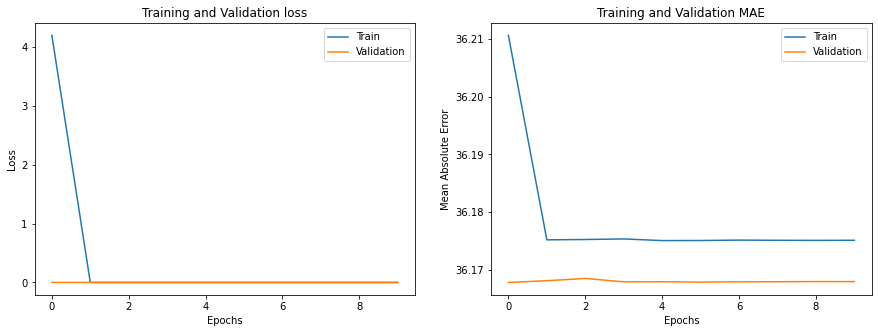

In [18]:
plot_history(history.history)

#### 2.1.1.2. Predicción de la red

In [19]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 30ms/step
Distance(m): [0.7106436734655005, 1029.1578230587836]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.394540,2.152301,1.268541,0.430498,0.838769,41.394340,2.151350,72.348077,0.000000,0.000000,82.412237
1,41.394658,2.152306,1.505828,0.745555,-0.051707,41.394340,2.151350,72.348077,0.000000,0.000000,87.214103
2,41.394573,2.152325,-1.259647,-2.219354,0.136868,41.394340,2.151350,72.348077,0.000000,0.000000,85.377184
3,41.394640,2.152397,0.597751,-0.362383,-0.946650,41.394340,2.151350,72.348077,0.000000,0.000000,93.498680
4,41.394632,2.152386,-0.649483,-0.236230,1.292361,41.394340,2.151350,72.348077,0.000000,0.000000,92.307900
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.398087,2.150061,1.270600,0.435259,0.835785,41.400268,2.151179,44.652289,7.775367,0.289365,259.869077
12006,41.398026,2.150106,1.507039,0.735265,-0.056938,41.400317,2.151234,39.488036,7.149873,-0.625495,271.590783
12007,41.398093,2.150162,-1.257676,-2.220518,0.130443,41.400383,2.151277,23.947936,8.208109,1.058236,271.080844
12008,41.398125,2.150218,0.599837,-0.365568,-0.938366,41.400452,2.151264,348.255669,8.071555,-0.136553,273.092906


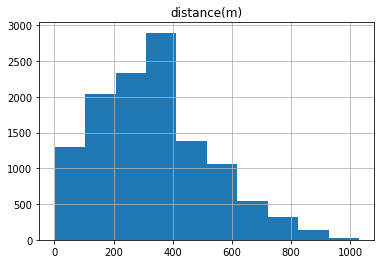

In [20]:
df_pred.hist('distance(m)')
plt.show()

In [21]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [22]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.7106436734655005, 1019.8126755153402]
Segundo 2: [3.84479841506105, 1023.0739286338679]
Segundo 3: [1.5996978022047161, 1025.5803503531897]
Segundo 4: [2.9514050023242313, 1029.1578230587836]
Segundo 5: [3.2744130144286663, 1026.0693029728097]


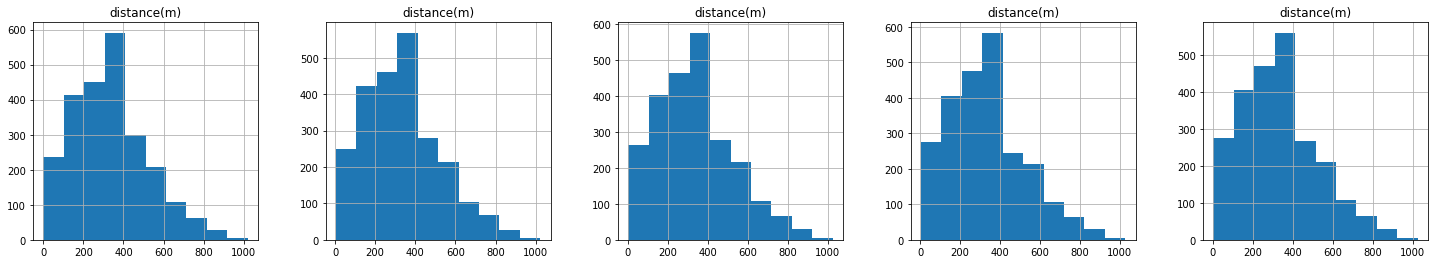

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [24]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396816,2.150384,1.276870,0.433258,0.841974,41.396994,2.149619,184.171392,5.743007,0.164075,335.230948
std,0.001008,0.001505,0.031891,0.018419,0.022320,0.002307,0.003671,98.232361,5.102721,1.308594,184.782896
min,41.393321,2.143399,1.122873,0.423894,0.789855,41.390906,2.139125,0.939814,0.000000,-10.000000,0.710644
25%,41.396314,2.149406,1.268768,0.426923,0.835470,41.395245,2.147242,101.919406,0.172846,-0.104516,192.045285
50%,41.396873,2.150240,1.270977,0.428593,0.836754,41.396960,2.149929,155.247244,4.966377,0.000000,324.709262
75%,41.397555,2.151628,1.272756,0.429918,0.838742,41.398961,2.151950,256.275266,10.340684,0.774525,436.388247
max,41.400087,2.154918,1.390158,0.567383,1.010303,41.401814,2.158624,357.404922,16.640354,5.988961,1019.812676


In [25]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396793,2.150375,1.519511,0.729584,-0.039202,41.396996,2.149621,184.160835,5.890808,0.147801,334.760754
std,0.001041,0.001514,0.029990,0.028785,0.028540,0.002308,0.003673,98.298534,4.947635,1.448525,186.705873
min,41.392738,2.143554,1.461334,0.608288,-0.142325,41.390873,2.139078,0.939814,0.000000,-10.000000,3.844798
25%,41.396132,2.149409,1.505876,0.718716,-0.054234,41.395234,2.147314,101.844412,0.968818,-0.154634,187.206129
50%,41.396820,2.150264,1.508274,0.746959,-0.053974,41.396960,2.149913,155.264593,5.239587,0.030756,321.843473
75%,41.397498,2.151654,1.510699,0.747395,-0.029180,41.398949,2.151951,256.443895,9.990617,0.898349,436.454663
max,41.399971,2.155174,1.652441,0.747840,0.073819,41.401864,2.158743,358.402101,16.602367,5.993102,1023.073929


In [26]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396779,2.150382,-1.259144,-2.209958,0.147358,41.396996,2.149623,184.186244,6.081826,0.191018,334.500811
std,0.001036,0.001507,0.002490,0.028887,0.022111,0.002308,0.003675,98.566199,4.650839,1.636780,187.758698
min,41.393197,2.143692,-1.267099,-2.299029,0.107860,41.390836,2.139009,0.373142,0.000000,-9.706740,1.599698
25%,41.396154,2.149456,-1.259309,-2.220545,0.135987,41.395221,2.147382,103.263678,2.096294,-0.201319,190.082963
50%,41.396788,2.150277,-1.259022,-2.218961,0.136669,41.396951,2.149961,155.606261,5.454008,0.089373,320.094846
75%,41.397509,2.151653,-1.258714,-2.217866,0.154276,41.398932,2.151952,262.182490,9.341440,1.054450,437.665359
max,41.399723,2.155910,-1.246208,-2.088757,0.234787,41.401915,2.158883,359.323010,16.546956,5.998546,1025.580350


In [27]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396799,2.150356,0.608619,-0.370947,-0.961189,41.396997,2.149625,183.173735,6.130936,0.049110,333.955057
std,0.001062,0.001496,0.024487,0.016474,0.034782,0.002309,0.003675,99.410339,4.357840,1.918388,188.753993
min,41.391667,2.143758,0.594447,-0.446680,-1.116998,41.390802,2.138863,2.280386,0.000000,-10.000000,2.951405
25%,41.396129,2.149365,0.596247,-0.365922,-0.951316,41.395206,2.147430,94.463904,2.726005,-0.410908,189.995366
50%,41.396818,2.150263,0.598449,-0.362945,-0.947291,41.396931,2.150051,160.120137,5.748746,0.085084,317.244983
75%,41.397506,2.151665,0.613838,-0.362493,-0.945512,41.398903,2.151970,268.070273,8.739849,1.113957,436.853683
max,41.400036,2.154616,0.770141,-0.361928,-0.884060,41.401967,2.158981,359.017348,16.626126,5.996870,1029.157823


In [28]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396764,2.150322,-0.665284,-0.245583,1.304991,41.396997,2.149628,176.707990,6.117309,0.105156,333.341353
std,0.001051,0.001513,0.033995,0.037519,0.024096,0.002309,0.003675,100.425471,4.092248,1.903228,188.286193
min,41.391894,2.143805,-0.817520,-0.385398,1.291260,41.390767,2.138725,0.598478,0.000000,-10.000000,3.274413
25%,41.396113,2.149342,-0.653729,-0.239805,1.293097,41.395191,2.147420,74.637179,3.188963,-0.242367,188.996016
50%,41.396796,2.150241,-0.651091,-0.237998,1.293419,41.396900,2.150056,147.086299,6.220898,0.103251,317.315847
75%,41.397451,2.151663,-0.650935,-0.234790,1.299155,41.398873,2.151995,261.391452,8.441894,1.059701,434.319905
max,41.399934,2.154334,-0.602650,-0.081964,1.416135,41.402028,2.159084,359.352131,16.601876,5.982253,1026.069303


#### 2.1.1.3. Métricas del modelo

In [29]:
# Load fitted model
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_LSTM_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 38
true_negative: 1162
Total colision: 1200
TP: 8
FN: 1192
Total no colision: 1200
FP: 38
TN: 1162

Accuracy: 0.4875
Precision: 0.17391304347826086
Recall: 0.006666666666666667
F1 Score: 0.012841091492776888
Specificity: 0.9683333333333334


In [30]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_LSTM_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
LSTM_UNITS=32

# Create, compile and fit model
lstm_model = make_lstm_model(LSTM_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(lstm_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_1 (Dense)             (None, 25)                825       
                                                                 
 reshape_1 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 5,689
Trainable params: 5,689
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 12667s 135ms/step - loss: 9.7035 - mean_absolute_error: 36.2822 - val_loss: 1.4646e-05 - val_mean_absolute_error: 36.1977 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 12

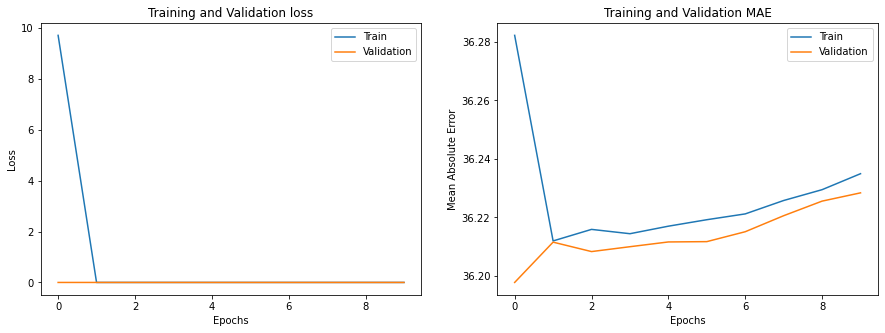

In [31]:
plot_history(history.history)

In [32]:
df_pred = model_predictions(lstm_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 27ms/step
Distance(m): [3.0229532729565793, 1387.7800948158329]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.395192,2.152312,0.028914,0.038800,0.266063,41.394340,2.151350,72.348077,0.000000,0.000000,124.123633
1,41.394926,2.152221,1.508053,1.019643,0.320031,41.394340,2.151350,72.348077,0.000000,0.000000,97.623849
2,41.394985,2.152373,-0.826876,-0.102983,-0.931623,41.394340,2.151350,72.348077,0.000000,0.000000,111.469549
3,41.395003,2.152226,-2.657051,0.955140,-0.637608,41.394340,2.151350,72.348077,0.000000,0.000000,103.770081
4,41.394913,2.152259,-0.141339,0.261860,-1.325821,41.394340,2.151350,72.348077,0.000000,0.000000,99.051035
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.396845,2.149633,0.020964,0.040055,0.264932,41.400268,2.151179,44.652289,7.775367,0.289365,401.802787
12006,41.397606,2.149856,1.507172,1.015725,0.319236,41.400317,2.151234,39.488036,7.149873,-0.625495,322.705333
12007,41.397486,2.149442,-0.828043,-0.104576,-0.937264,41.400383,2.151277,23.947936,8.208109,1.058236,356.667501
12008,41.397431,2.149869,-2.664359,0.948921,-0.640209,41.400452,2.151264,348.255669,8.071555,-0.136553,355.587791


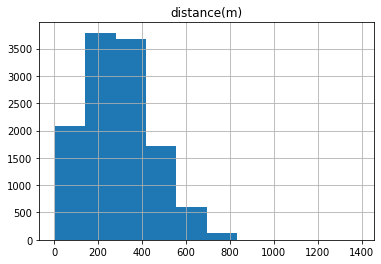

In [33]:
df_pred.hist('distance(m)')
plt.show()

In [34]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [35]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [5.199303389218141, 1238.0288040498394]
Segundo 2: [3.7131158360659064, 1333.3521160396203]
Segundo 3: [7.217093502503691, 1236.5915376205012]
Segundo 4: [3.0229532729565793, 1346.9086822111447]
Segundo 5: [5.794834298123229, 1387.7800948158329]


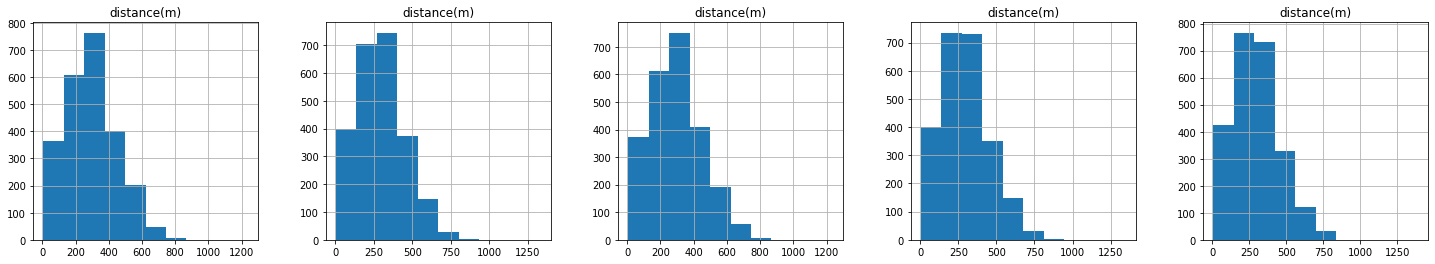

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [37]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396666,2.149903,0.019431,0.040004,0.264943,41.396994,2.149619,184.171392,5.743007,0.164075,296.940720
std,0.000944,0.001904,0.005348,0.001052,0.000543,0.002307,0.003671,98.232361,5.102721,1.308594,152.675156
min,41.389023,2.144490,0.004286,0.036172,0.263493,41.390906,2.139125,0.939814,0.000000,-10.000000,5.199303
25%,41.396323,2.148571,0.015571,0.039224,0.264534,41.395245,2.147242,101.919406,0.172846,-0.104516,184.498930
50%,41.396851,2.150038,0.020241,0.039956,0.264968,41.396960,2.149929,155.247244,4.966377,0.000000,283.237709
75%,41.397278,2.151370,0.022864,0.040739,0.265339,41.398961,2.151950,256.275266,10.340684,0.774525,389.074671
max,41.400971,2.157100,0.041084,0.042968,0.266838,41.401814,2.158624,357.404922,16.640354,5.988961,1238.028804


In [38]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396780,2.149937,1.507033,1.014996,0.318754,41.396996,2.149621,184.160835,5.890808,0.147801,296.382885
std,0.001012,0.001890,0.000996,0.002611,0.000820,0.002308,0.003673,98.298534,4.947635,1.448525,154.055236
min,41.388011,2.144499,1.504061,1.007571,0.316334,41.390873,2.139078,0.939814,0.000000,-10.000000,3.713116
25%,41.396269,2.148626,1.506332,1.013098,0.318171,41.395234,2.147314,101.844412,0.968818,-0.154634,181.408500
50%,41.396932,2.150084,1.507178,1.015313,0.318846,41.396960,2.149913,155.264593,5.239587,0.030756,286.188795
75%,41.397424,2.151377,1.507774,1.016685,0.319370,41.398949,2.151951,256.443895,9.990617,0.898349,390.772700
max,41.400976,2.157166,1.511327,1.025571,0.323225,41.401864,2.158743,358.402101,16.602367,5.993102,1333.352116


In [39]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396759,2.149880,-0.828491,-0.104895,-0.939289,41.396996,2.149623,184.186244,6.081826,0.191018,296.794374
std,0.001017,0.001900,0.000938,0.001079,0.004334,0.002308,0.003675,98.566199,4.650839,1.636780,154.251565
min,41.388819,2.144556,-0.831005,-0.107873,-0.951225,41.390836,2.139009,0.373142,0.000000,-9.706740,7.217094
25%,41.396253,2.148526,-0.829141,-0.105657,-0.942422,41.395221,2.147382,103.263678,2.096294,-0.201319,186.957600
50%,41.396928,2.150022,-0.828454,-0.104876,-0.938981,41.396951,2.149961,155.606261,5.454008,0.089373,285.118643
75%,41.397416,2.151375,-0.827870,-0.104225,-0.936222,41.398932,2.151952,262.182490,9.341440,1.054450,387.652220
max,41.401143,2.157013,-0.822583,-0.100797,-0.922359,41.401915,2.158883,359.323010,16.546956,5.998546,1236.591538


In [40]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396762,2.149940,-2.664663,0.948846,-0.641399,41.396997,2.149625,183.173735,6.130936,0.049110,295.856392
std,0.001029,0.001897,0.004258,0.003791,0.002199,0.002309,0.003675,99.410339,4.357840,1.918388,156.538635
min,41.387918,2.144450,-2.676591,0.937880,-0.647639,41.390802,2.138863,2.280386,0.000000,-10.000000,3.022953
25%,41.396270,2.148612,-2.667772,0.946160,-0.642977,41.395206,2.147430,94.463904,2.726005,-0.410908,184.609809
50%,41.396945,2.150102,-2.664086,0.949461,-0.641183,41.396931,2.150051,160.120137,5.748746,0.085084,283.609314
75%,41.397423,2.151392,-2.662040,0.951310,-0.639734,41.398903,2.151970,268.070273,8.739849,1.113957,390.302756
max,41.400976,2.157197,-2.647157,0.964486,-0.632209,41.401967,2.158981,359.017348,16.626126,5.996870,1346.908682


In [41]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396773,2.149931,-0.142504,0.258463,-1.334373,41.396997,2.149628,176.707990,6.117309,0.105156,296.279501
std,0.001019,0.001893,0.000578,0.002059,0.004626,0.002309,0.003675,100.425471,4.092248,1.903228,156.677381
min,41.387510,2.144477,-0.144266,0.252410,-1.347020,41.390767,2.138725,0.598478,0.000000,-10.000000,5.794834
25%,41.396308,2.148614,-0.142900,0.256988,-1.337630,41.395191,2.147420,74.637179,3.188963,-0.242367,184.237130
50%,41.396966,2.150085,-0.142452,0.258815,-1.333946,41.396900,2.150056,147.086299,6.220898,0.103251,283.869406
75%,41.397419,2.151399,-0.142150,0.259795,-1.331390,41.398873,2.151995,261.391452,8.441894,1.059701,387.587468
max,41.401490,2.157155,-0.140136,0.266897,-1.315846,41.402028,2.159084,359.352131,16.601876,5.982253,1387.780095


In [42]:
# Load fitted model
MODELS_FOLDER =  './'
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_LSTM_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 0
true_negative: 1200
Total colision: 1200
TP: 1
FN: 1199
Total no colision: 1200
FP: 0
TN: 1200

Accuracy: 0.5004166666666666
Precision: 1.0
Recall: 0.0008333333333333334
F1 Score: 0.0016652789342214824
Specificity: 1.0


In [16]:
def make_gru_model(units, in_steps, out_steps, in_features, out_features):
    gru_model = Sequential()

    # Shape [batch, time, in_features] => [batch, gru_units].
    gru_model.add(GRU(units, input_shape=(in_steps, in_features)))

    # Shape => [batch, out_steps*out_features].
    gru_model.add(Dense(out_steps*out_features))

    # Shape => [batch, out_steps, out_features].
    gru_model.add(Reshape([out_steps, out_features]))

    gru_model.summary()

    return gru_model

In [17]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_GRU_32units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=32

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3744      
                                                                 
 dense (Dense)               (None, 25)                825       
                                                                 
 reshape (Reshape)           (None, 5, 5)              0         
                                                                 
Total params: 4,569
Trainable params: 4,569
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 10792s 115ms/step - loss: 8.6372 - mean_absolute_error: 36.4898 - val_loss: 1.8826e-05 - val_mean_absolute_error: 36.4128 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 1151

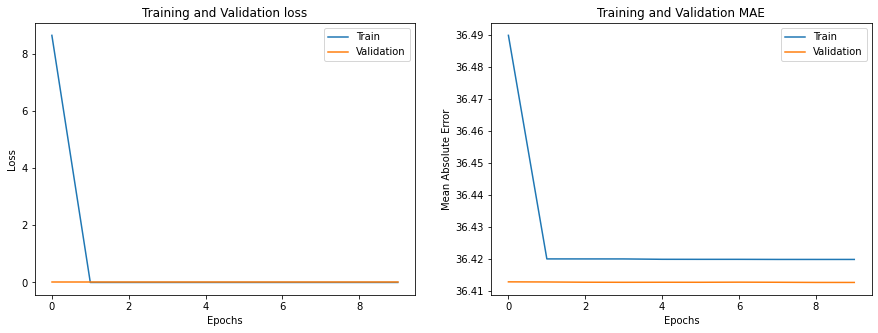

In [18]:
plot_history(history.history)

In [20]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 2s 27ms/step
Distance(m): [0.6614968692559348, 1161.1848238884932]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.396500,2.151311,1.771973,-2.044550,-1.358826,41.394340,2.151350,72.348077,0.000000,0.000000,240.239514
1,41.396531,2.151412,-1.058417,-0.563229,0.433589,41.394340,2.151350,72.348077,0.000000,0.000000,243.645856
2,41.396378,2.151250,-3.231562,-0.580507,-1.086986,41.394340,2.151350,72.348077,0.000000,0.000000,226.781705
3,41.396317,2.151452,-0.749655,-0.512704,1.354107,41.394340,2.151350,72.348077,0.000000,0.000000,219.982455
4,41.396400,2.151365,0.999788,0.295766,-1.155596,41.394340,2.151350,72.348077,0.000000,0.000000,229.027122
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.397770,2.151326,1.772167,-2.044696,-1.358594,41.400268,2.151179,44.652289,7.775367,0.289365,278.046135
12006,41.397820,2.151530,-1.058432,-0.563360,0.433772,41.400317,2.151234,39.488036,7.149873,-0.625495,278.798750
12007,41.397412,2.151170,-3.231749,-0.580609,-1.086959,41.400383,2.151277,23.947936,8.208109,1.058236,330.427667
12008,41.397335,2.151462,-0.749793,-0.512800,1.354151,41.400452,2.151264,348.255669,8.071555,-0.136553,347.029339


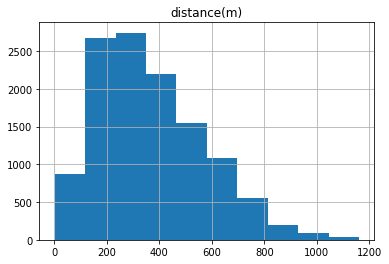

In [21]:
df_pred.hist('distance(m)')
plt.show()

In [22]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [23]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [0.6614968692559348, 1106.0878785051764]
Segundo 2: [21.777566705275945, 1137.1955636969046]
Segundo 3: [29.73074433548652, 1108.6086515508066]
Segundo 4: [17.20990935091228, 1143.0774843816243]
Segundo 5: [14.579400092354879, 1161.1848238884932]


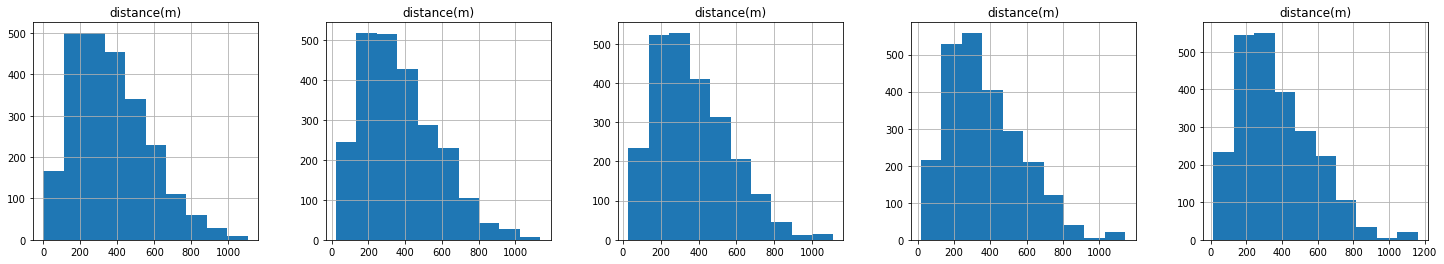

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [25]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396910,2.151351,1.772030,-2.044600,-1.358754,41.396994,2.149619,184.171392,5.743007,0.164075,367.060775
std,0.000986,0.000044,0.000161,0.000112,0.000191,0.002307,0.003671,98.232361,5.102721,1.308594,202.317889
min,41.393184,2.151029,1.771400,-2.044751,-1.359501,41.390906,2.139125,0.939814,0.000000,-10.000000,0.661497
25%,41.396404,2.151324,1.771952,-2.044696,-1.358844,41.395245,2.147242,101.919406,0.172846,-0.104516,205.438926
50%,41.397114,2.151337,1.772070,-2.044625,-1.358698,41.396960,2.149929,155.247244,4.966377,0.000000,337.758175
75%,41.397752,2.151367,1.772164,-2.044527,-1.358598,41.398961,2.151950,256.275266,10.340684,0.774525,496.467635
max,41.398121,2.151514,1.772212,-2.044218,-1.358554,41.401814,2.158624,357.404922,16.640354,5.988961,1106.087879


In [26]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396942,2.151438,-1.058394,-0.563253,0.433641,41.396996,2.149621,184.160835,5.890808,0.147801,370.582355
std,0.001009,0.000107,0.000094,0.000130,0.000170,0.002308,0.003673,98.298534,4.947635,1.448525,206.483425
min,41.393108,2.151021,-1.058660,-0.563427,0.432977,41.390873,2.139078,0.939814,0.000000,-10.000000,21.777567
25%,41.396436,2.151387,-1.058443,-0.563361,0.433567,41.395234,2.147314,101.844412,0.968818,-0.154634,206.298650
50%,41.397156,2.151463,-1.058420,-0.563286,0.433719,41.396960,2.149913,155.264593,5.239587,0.030756,341.505814
75%,41.397803,2.151528,-1.058365,-0.563188,0.433770,41.398949,2.151951,256.443895,9.990617,0.898349,505.054403
max,41.398167,2.151566,-1.058044,-0.562802,0.433787,41.401864,2.158743,358.402101,16.602367,5.993102,1137.195564


In [27]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396747,2.151274,-3.231632,-0.580524,-1.087017,41.396996,2.149623,184.186244,6.081826,0.191018,366.591466
std,0.000765,0.000167,0.000135,0.000142,0.000112,0.002308,0.003675,98.566199,4.650839,1.636780,197.735993
min,41.393831,2.151047,-3.231788,-0.580787,-1.087416,41.390836,2.139009,0.373142,0.000000,-9.706740,29.730744
25%,41.396367,2.151170,-3.231746,-0.580610,-1.087056,41.395221,2.147382,103.263678,2.096294,-0.201319,215.688828
50%,41.396922,2.151188,-3.231663,-0.580593,-1.086968,41.396951,2.149961,155.606261,5.454008,0.089373,333.765317
75%,41.397398,2.151336,-3.231565,-0.580470,-1.086954,41.398932,2.151952,262.182490,9.341440,1.054450,493.791547
max,41.397645,2.151906,-3.231120,-0.580019,-1.086735,41.401915,2.158883,359.323010,16.546956,5.998546,1108.608652


In [28]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396700,2.151426,-0.749675,-0.512717,1.354092,41.396997,2.149625,183.173735,6.130936,0.049110,370.590320
std,0.000723,0.000091,0.000140,0.000104,0.000119,0.002309,0.003675,99.410339,4.357840,1.918388,202.889678
min,41.394013,2.151085,-0.749844,-0.512859,1.353654,41.390802,2.138863,2.280386,0.000000,-10.000000,17.209909
25%,41.396322,2.151399,-0.749790,-0.512804,1.354052,41.395206,2.147430,94.463904,2.726005,-0.410908,209.413713
50%,41.396852,2.151450,-0.749710,-0.512744,1.354137,41.396931,2.150051,160.120137,5.748746,0.085084,334.070321
75%,41.397322,2.151473,-0.749610,-0.512666,1.354155,41.398903,2.151970,268.070273,8.739849,1.113957,504.591709
max,41.397588,2.151687,-0.749133,-0.512313,1.354375,41.401967,2.158981,359.017348,16.626126,5.996870,1143.077484


In [29]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396797,2.151408,0.999808,0.295809,-1.155624,41.396997,2.149628,176.707990,6.117309,0.105156,368.034912
std,0.000857,0.000047,0.000115,0.000088,0.000149,0.002309,0.003675,100.425471,4.092248,1.903228,205.297494
min,41.393654,2.151124,0.999390,0.295476,-1.155811,41.390767,2.138725,0.598478,0.000000,-10.000000,14.579400
25%,41.396312,2.151374,0.999762,0.295760,-1.155750,41.395191,2.147420,74.637179,3.188963,-0.242367,208.625464
50%,41.396971,2.151421,0.999868,0.295771,-1.155660,41.396900,2.150056,147.086299,6.220898,0.103251,334.083500
75%,41.397539,2.151448,0.999881,0.295838,-1.155555,41.398873,2.151995,261.391452,8.441894,1.059701,505.402539
max,41.397890,2.151474,0.999996,0.296122,-1.155060,41.402028,2.159084,359.352131,16.601876,5.982253,1161.184824


In [30]:
# Load fitted model
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_GRU_32units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 106
true_negative: 1094
Total colision: 1200
TP: 20
FN: 1180
Total no colision: 1200
FP: 106
TN: 1094

Accuracy: 0.46416666666666667
Precision: 0.15873015873015872
Recall: 0.016666666666666666
F1 Score: 0.030165912518853696
Specificity: 0.9116666666666666


In [31]:
# Create model folder
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_GRU_64units")
os.makedirs(MODEL_FOLDER, exist_ok=True)

# Model parameters
GRU_UNITS=64

# Create, compile and fit model
gru_model = make_gru_model(GRU_UNITS, INPUT_WIDTH, OUTPUT_WIDTH,
                             len(INPUT_COL), len(OUTPUT_COL))
history = compile_and_fit(gru_model, X_train, y_train, X_val, y_val,
                          MODEL_FOLDER, epochs=EPOCHS, batch_size=BATCH_SIZE,
                          patience=PATIENCE, reduce_lr=REDUCELR)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 64)                13632     
                                                                 
 dense_1 (Dense)             (None, 25)                1625      
                                                                 
 reshape_1 (Reshape)         (None, 5, 5)              0         
                                                                 
Total params: 15,257
Trainable params: 15,257
Non-trainable params: 0
_________________________________________________________________
X_train.shape: (6005877, 20, 5)
y_train.shape: (6005877, 5, 5)
Epoch 1/10
93842/93842 [==============================] - 16992s 181ms/step - loss: 3.9203 - mean_absolute_error: 36.2132 - val_loss: 2.2717e-05 - val_mean_absolute_error: 36.1725 - lr: 0.0010
Epoch 2/10
93842/93842 [==============================] - 

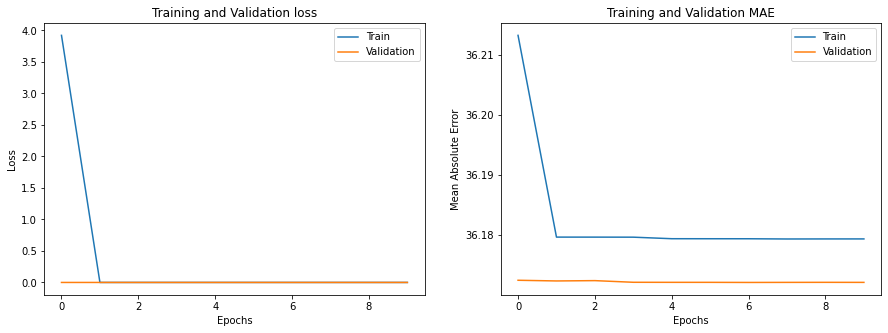

In [32]:
plot_history(history.history)

In [33]:
df_pred = model_predictions(gru_model, X_test, y_test)
print("Distance(m): [{}, {}]".format(min(df_pred['distance(m)']),
                                     max(df_pred['distance(m)'])))
df_pred

76/76 [==============================] - 3s 33ms/step
Distance(m): [1.6926091660977955, 1059.3421291936518]


,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
0,41.394947,2.151056,1.476056,0.413054,-1.687210,41.394340,2.151350,72.348077,0.000000,0.000000,71.806290
1,41.394367,2.151517,1.263036,-0.261092,0.318046,41.394340,2.151350,72.348077,0.000000,0.000000,14.293772
2,41.394185,2.150884,0.861556,0.111992,0.906017,41.394340,2.151350,72.348077,0.000000,0.000000,42.516718
3,41.394386,2.151447,-0.695686,-0.699962,2.632451,41.394340,2.151350,72.348077,0.000000,0.000000,9.579813
4,41.394947,2.151348,1.598354,-1.040249,-2.417477,41.394340,2.151350,72.348077,0.000000,0.000000,67.438713
...,...,...,...,...,...,...,...,...,...,...,...
12005,41.398049,2.149519,1.476196,0.411041,-1.686466,41.400268,2.151179,44.652289,7.775367,0.289365,282.912385
12006,41.398029,2.149764,1.263373,-0.262229,0.318116,41.400317,2.151234,39.488036,7.149873,-0.625495,282.386243
12007,41.398282,2.149564,0.859924,0.111922,0.906015,41.400383,2.151277,23.947936,8.208109,1.058236,273.859968
12008,41.398236,2.149754,-0.697125,-0.700284,2.632840,41.400452,2.151264,348.255669,8.071555,-0.136553,276.759378


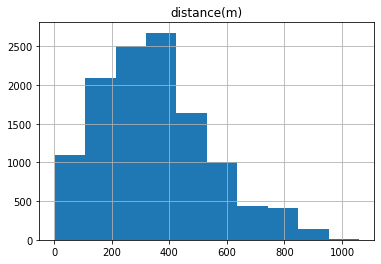

In [34]:
df_pred.hist('distance(m)')
plt.show()

In [35]:
n_rows = df_pred.shape[0]
list_1seg, list_2seg, list_3seg, list_4seg, list_5seg = \
  [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows, [False]*n_rows

for i in range(n_rows):
    if i%5 == 0:
        list_1seg[i] = True
    elif i%5 == 1:
        list_2seg[i] = True
    elif i%5 == 2:
        list_3seg[i] = True
    elif i%5 == 3:
        list_4seg[i] = True
    elif i%5 == 4:
        list_5seg[i] = True

df_pred_1seg = df_pred.iloc[list_1seg, :]
df_pred_2seg = df_pred.iloc[list_2seg, :]
df_pred_3seg = df_pred.iloc[list_3seg, :]
df_pred_4seg = df_pred.iloc[list_4seg, :]
df_pred_5seg = df_pred.iloc[list_5seg, :]

In [36]:
print("Segundo 1: [{}, {}]".format(min(df_pred_1seg['distance(m)']),
                                   max(df_pred_1seg['distance(m)'])))
print("Segundo 2: [{}, {}]".format(min(df_pred_2seg['distance(m)']),
                                   max(df_pred_2seg['distance(m)'])))
print("Segundo 3: [{}, {}]".format(min(df_pred_3seg['distance(m)']),
                                   max(df_pred_3seg['distance(m)'])))
print("Segundo 4: [{}, {}]".format(min(df_pred_4seg['distance(m)']),
                                   max(df_pred_4seg['distance(m)'])))
print("Segundo 5: [{}, {}]".format(min(df_pred_5seg['distance(m)']),
                                   max(df_pred_5seg['distance(m)'])))

Segundo 1: [14.499843107455135, 1032.0680415515324]
Segundo 2: [1.6926091660977955, 1045.540330968299]
Segundo 3: [8.290944255735097, 1037.3841730690692]
Segundo 4: [2.898958934469308, 1054.7066661547865]
Segundo 5: [7.147911268629839, 1059.3421291936518]


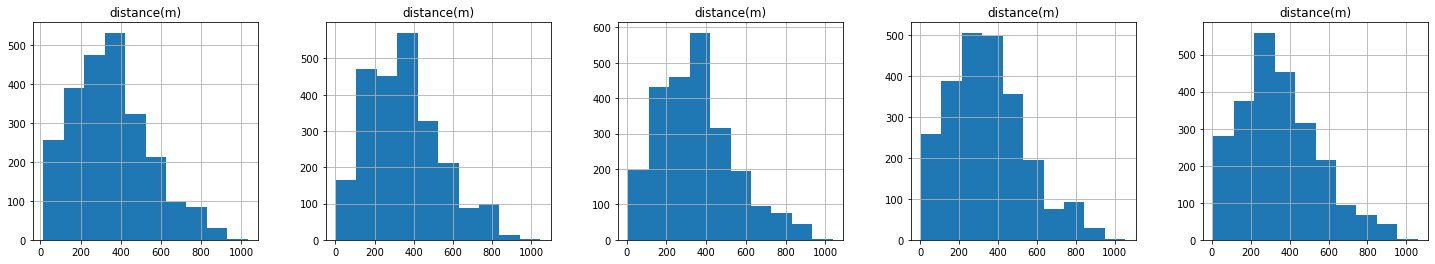

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(25,4))
df_pred_1seg.hist('distance(m)', ax=ax[0])
df_pred_2seg.hist('distance(m)', ax=ax[1])
df_pred_3seg.hist('distance(m)', ax=ax[2])
df_pred_4seg.hist('distance(m)', ax=ax[3])
df_pred_5seg.hist('distance(m)', ax=ax[4])
plt.show()

In [38]:
df_pred_1seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396491,2.150268,1.476506,0.411667,-1.686622,41.396994,2.149619,184.171392,5.743007,0.164075,348.521996
std,0.001028,0.001272,0.000308,0.000997,0.000547,0.002307,0.003671,98.232361,5.102721,1.308594,187.117400
min,41.389294,2.147737,1.475511,0.409570,-1.687247,41.390906,2.139125,0.939814,0.000000,-10.000000,14.499843
25%,41.395751,2.149108,1.476329,0.410813,-1.687145,41.395245,2.147242,101.919406,0.172846,-0.104516,205.469276
50%,41.396728,2.150317,1.476466,0.411758,-1.686755,41.396960,2.149929,155.247244,4.966377,0.000000,329.602903
75%,41.397250,2.151477,1.476589,0.412571,-1.686153,41.398961,2.151950,256.275266,10.340684,0.774525,456.421722
max,41.398357,2.153354,1.478339,0.413850,-1.685178,41.401814,2.158624,357.404922,16.640354,5.988961,1032.068042


In [39]:
df_pred_2seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396579,2.150419,1.262816,-0.261631,0.318395,41.396996,2.149621,184.160835,5.890808,0.147801,348.599243
std,0.001054,0.001094,0.000485,0.000794,0.000244,0.002308,0.003673,98.298534,4.947635,1.448525,186.297140
min,41.390409,2.148195,1.259930,-0.263028,0.317712,41.390873,2.139078,0.939814,0.000000,-10.000000,1.692609
25%,41.395707,2.149440,1.262631,-0.262367,0.318228,41.395234,2.147314,101.844412,0.968818,-0.154634,203.429372
50%,41.396871,2.150430,1.262961,-0.261650,0.318339,41.396960,2.149913,155.264593,5.239587,0.030756,332.280435
75%,41.397415,2.151465,1.263156,-0.260977,0.318599,41.398949,2.151951,256.443895,9.990617,0.898349,449.763781
max,41.398192,2.153046,1.263889,-0.259209,0.320091,41.401864,2.158743,358.402101,16.602367,5.993102,1045.540331


In [40]:
df_pred_3seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396641,2.150268,0.860525,0.111727,0.905519,41.396996,2.149623,184.186244,6.081826,0.191018,350.637539
std,0.001191,0.001279,0.000659,0.000156,0.000474,0.002308,0.003675,98.566199,4.650839,1.636780,187.831729
min,41.389392,2.147569,0.859507,0.110656,0.902997,41.390836,2.139009,0.373142,0.000000,-9.706740,8.290944
25%,41.395846,2.149095,0.859903,0.111630,0.905265,41.395221,2.147382,103.263678,2.096294,-0.201319,208.870280
50%,41.396946,2.150372,0.860476,0.111758,0.905655,41.396951,2.149961,155.606261,5.454008,0.089373,328.724632
75%,41.397573,2.151485,0.860998,0.111826,0.905846,41.398932,2.151952,262.182490,9.341440,1.054450,451.012315
max,41.398470,2.153059,0.863003,0.112255,0.906878,41.401915,2.158883,359.323010,16.546956,5.998546,1037.384173


In [41]:
df_pred_4seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396480,2.150366,-0.696646,-0.699863,2.632477,41.396997,2.149625,183.173735,6.130936,0.049110,348.511867
std,0.001176,0.001159,0.000972,0.000619,0.000256,0.002309,0.003675,99.410339,4.357840,1.918388,194.014801
min,41.388392,2.147838,-0.698812,-0.701368,2.630564,41.390802,2.138863,2.280386,0.000000,-10.000000,2.898959
25%,41.395734,2.149320,-0.697514,-0.700414,2.632372,41.395206,2.147430,94.463904,2.726005,-0.410908,201.953095
50%,41.396746,2.150490,-0.696543,-0.699936,2.632518,41.396931,2.150051,160.120137,5.748746,0.085084,326.613504
75%,41.397344,2.151490,-0.695676,-0.699332,2.632648,41.398903,2.151970,268.070273,8.739849,1.113957,462.268887
max,41.398578,2.152581,-0.694919,-0.697857,2.632928,41.401967,2.158981,359.017348,16.626126,5.996870,1054.706666


In [42]:
df_pred_5seg.describe()

,latitude(pred),longitude(pred),heading(pred),speed(m/s)(pred),acceleration(m/s²)(pred),latitude,longitude,heading,speed(m/s),acceleration(m/s²),distance(m)
count,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000,2402.000000
mean,41.396417,2.150413,1.598644,-1.040163,-2.417476,41.396997,2.149628,176.707990,6.117309,0.105156,350.429038
std,0.001075,0.001111,0.000483,0.000401,0.000815,0.002309,0.003675,100.425471,4.092248,1.903228,195.243647
min,41.388554,2.148730,1.596143,-1.042353,-2.420142,41.390767,2.138725,0.598478,0.000000,-10.000000,7.147911
25%,41.395765,2.149377,1.598364,-1.040360,-2.418169,41.395191,2.147420,74.637179,3.188963,-0.242367,205.848896
50%,41.396707,2.150272,1.598829,-1.040034,-2.417426,41.396900,2.150056,147.086299,6.220898,0.103251,320.803528
75%,41.397184,2.151275,1.599042,-1.039835,-2.416738,41.398873,2.151995,261.391452,8.441894,1.059701,461.355241
max,41.398484,2.154640,1.599233,-1.039571,-2.415634,41.402028,2.159084,359.352131,16.601876,5.982253,1059.342129


In [43]:
# Load fitted model
MODEL_FOLDER = os.path.join(MODELS_FOLDER, "simple_v3", "PINN_GRU_64units")
MODEL_FILE = os.path.join(MODEL_FOLDER, "model_saved.hdf5")
model = tf.keras.models.load_model(MODEL_FILE, compile=False) #https://stackoverflow.com/questions/48373845/loading-model-with-custom-loss-keras

# Get test metrics
METRICS_FILE = os.path.join(MODEL_FOLDER, "metrics.txt")
get_metrics(model, X_test, df, vehicle_ids, df_col, df_nocol, df_dim, METRICS_FILE)

coinciden y colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
coinciden pero no colisionan: 2120
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
false_positive: 52
true_negative: 1148
Total colision: 1200
TP: 12
FN: 1188
Total no colision: 1200
FP: 52
TN: 1148

Accuracy: 0.48333333333333334
Precision: 0.1875
Recall: 0.01
F1 Score: 0.018987341772151896
Specificity: 0.9566666666666667
